# 

In [ ]:
 def conver_to_numeric(self, types):
        '''
        Convert non-numeric columns into numeric values
        types : list of boolean-values represent the type of categorical features 
                for nominal : None 
                for ordinal : dict of correct ordar, ex: { a:0, b:1}
                the length of list must be equel to the number of categorical features
                
        return the orginal DataFrame after applay converting 
        '''
        
        cate_names = self.__categorical.dtypes[self.__categorical.dtypes == object].index
        
        if len(types) != len(cate_names):
            print("the length of list must be equel to the number of non-numer-categorical features")
            return None
        else:
            for i in range(len(types)):

                print(np.unique(self.__categorical[cate_names[i]].astype(str)))
                uniValues = np.unique(self.__categorical[cate_names[i]].astype(str))
                
                if types[i] == None:
                    print(cate_names[i], uniValues)
                    if len(uniValues) == 2: 
                        self.__categorical[cate_names[i]] = self.__categorical[cate_names[i]].replace(uniValues, [0,1])
                        pass
                    else:
                        self.__categorical = pd.concat([self.__categorical,
                                                   pd.get_dummies(self.__categorical[cate_names[i]], dtype=int, 
                                   columns=uniValues)])
                                                    
                        self.__categorical = self.__categorical.drop([cate_names[i]],axis=1)
                        pass
                    pass
                else: 
                    if type(types[i]) == dict:
                        if list(types[i].keys()) == uniValues:
                            self.__categorical[cate_names[i]] = self.__categorical[cate_names[i]].map(types[i])  
                            pass
                        else:
                            print("values of " +uniValues+" not match")
                        return None
                    else: 
                        print("this not doctionary")
                        return None
                    pass 
                pass
            pass
        print(self.__categorical['Male'].head())
        print()
        print(self.__categorical['Female'].head())
        #return pd.concat([self.__categorical, self.__continues], axis = 1)

# Load Libraries

In [10]:
import tensorflow as tf

import numpy as np
from dateutil.parser import parse
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd

import matplotlib.pyplot as py
import seaborn as sb
  
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb 

from hyperopt import hp, tpe, fmin, Trials
#import neptunecontrib.hpo.utils as hpo_utils
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score, train_test_split

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Avoid OOM errors by setting GPU Memory Consumption Growth

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    pass

# EDA & Preprocessing

## Class

In [11]:
class EDA:
    '''
    this class
       handles with missing values in the dataset (replace it)
       perform some visualization plots on data  
       
    load dataset from path or assign as pandas.DataFrame
    then handle missing values ... before anything
    '''
    
    # split dataframe into categorical & continues to make visualization easy
    # add features after handling missing values
    __categorical, __continues, __date_columns = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    __cont_len, __cate_len = 0, 0
    
    def __init__(self, dataset, num_unique_values, perc_miss, target_index = None):
        '''
        dataset : Path (location) of dataset to which the operations will be applied or pandas.DaFrame
        num_unique_values : Number of unique values in a feature has 'int datatype',
                            to deal with it as categorical feature.
                    
        perc_miss : Percentage of missing values in a feature
                    in case the percentage of missing values more than 'perc_miss'
                    the feature is removed from dataset
                    
        target_index : the index of target feature | None, in case no target
        ''' 
        
        try :
            self.path_dataset = dataset
            self.nuv = num_unique_values
            self.pm = perc_miss
            self.tar_index = target_index
            ######################
        
            if type(dataset) == type(self.__categorical):
                self.dataFrame = dataset; pass
            else : self.dataFrame = pd.read_csv(self.path_dataset)
            self.numRec = len(self.dataFrame)  
            ##
             # boolean not work during plot 
            if target_index != None:
                self.target = self.dataFrame.iloc[:,self.tar_index] 
                if self.target .dtype == bool:
                    self.target .replace([True, False], [1,0])
                    pass
                pass
            else : self.target = None
            ##
            self.__handle();
            pass
        
        except Exception as e:
            print(e,e.with_traceback); pass 
        pass
    
    def about_dataset(self):
        '''
        '''
        print("\n Dataset has : ",self.numRec, " records (samples)")
        print("\n Dataset has : ", self.__cate_len, " categorical features :       "+
              self.__categorical.columns)
        print("\n Dataset has : ",self.__cont_len, " continues features :        "+
              self.__continues.columns)
        
        print("\n######################## Number of nulls ########################\n")
        print(self.dataFrame.isnull().sum())
        print("\n######################## information ########################\n")
        print(self.dataFrame.info())
        print("\n######################## description ########################\n")
        print(self.dataFrame.describe())
        pass
    
    ## Pre-processing
    
    def __handle(self):
        '''
        replace each null-value with:
                mean in continuous features
                mode in categorical features
        -------------------------------------
        and handle  boolean feature    
        '''
        
        
        for column in self.dataFrame.columns[:-1]:
            if self.dataFrame[column].isnull().sum() / self.numRec >= self.pm:
                self.dataFrame = self.dataFrame.drop(columns=column, axis=1)
                pass
            elif self.dataFrame[column].dtype in \
                             (np.int8, np.int16, np.int32, np.int64,np.int_, np.int0):
                # Suppose a feature is a categorical feature when it has a maximum of 10 categories..
                # [ class '1' | class '2' | class '3' ]
                if len(self.dataFrame[column].unique()) <= self.nuv :
                    self.dataFrame[column][self.dataFrame[column].isnull()] = self.dataFrame[column].mode()[0]    
                    self.__categorical[column] = self.dataFrame[column]
                    pass
                
                else:
                    self.dataFrame[column][self.dataFrame[column].isnull()] = self.dataFrame[column].mean()
                    self.__continues[column] = self.dataFrame[column]
                    pass
                pass
            
            elif self.dataFrame[column].dtype == object:
                self.dataFrame[column][self.dataFrame[column].isnull()] = self.dataFrame[column].mode()[0]
                try:
                    parse(self.dataFrame[column][0])
                    date = pd.to_datetime(self.dataFrame[column])
                    date = [[da.year, da.month, da.day] for da in date]
                    date = pd.DataFrame(date, columns=[column +' year', column +' month',column +' day'])
                  
                    self.__date_columns = pd.concat([self.__date_columns, date], axis=1) 
                    pass
                except Exception:
                    self.__categorical[column] = self.dataFrame[column]; pass
                pass
            
            elif self.dataFrame[column].dtype in (np.float16, np.float32, np.float64):
                self.dataFrame[column][self.dataFrame[column].isnull()] = self.dataFrame[column].mean()
                self.__continues[column] = self.dataFrame[column]
                pass
            
            elif self.dataFrame[column].dtype == bool:
                self.__categorical[column] = self.target.replace([True, False], [1,0])
                self.__categorical[column][self.__categorical[column].isnull()] = \
                     self.__categorical[column].mode()[0]
                pass
            pass
        self.__cont_len = np.shape(self.__continues)[1]
        self.__cate_len = np.shape(self.__categorical)[1]
        pass
    
    ### Continues features
    
    def hist_plot(self):
        '''
        plot histogram for each Continues feature in dataset
        '''
        try:
            for column in self.__continues.columns:
                sb.histplot(x=self.__continues[column], hue = self.target ,kde=True)
                py.show(); pass
            pass
        except Exception as e:
            print(e,e.with_traceback); pass 
        pass
    
    def box_plot(self):
        '''
        plot histogram for each Continues feature in dataset
        '''
        try:
            for column in self.__continues.columns:
                sb.boxplot(x=self.__continues[column], hue = self.target)
                py.show(); pass
            pass 
        except Exception as e:
            print(e,e.with_traceback); pass 
        pass
    
    def pairplot(self):
        '''
        plot pairplot for each Continues feature in dataset
        '''
        try:
            fig, axs = py.subplots(1, 1, figsize=(5*self.__cont_len,5))
            sb.pairplot(data=self.__continue, ax=axs)
            py.show(); pass 
        except Exception as e:
            print(e,e.with_traceback); pass 
        pass
    
    def correlation(self):
        '''
        plot heatmap of correlation between Continues features in dataset
        '''
        try:
            fig, axs = py.subplots(1, 1, figsize=(5*self.__cont_len,5))
            sb.heatmap(data=self.__continues.corr(),annot=True, ax=axs)
            py.show(); pass 
        except Exception as e:
            print(e,e.with_traceback); pass 
        pass
    
     ### Categorical features 
    
    def count_plot(self):
        '''
        plot countplot for each Continues feature in dataset
        ''' 
        try:
            for column in self.__categorical.columns:
                sb.countplot(self.__categorical[column], hue = self.target)
                py.show();   
                pass 
            
            # shape of date_columns (dataframe contains date-columns)
            # for one date-column (in orginal dataset), after split 
                # 'columnName year' 'columnName month' 'columnName day'
            
            l = np.shape(self.__date_columns)[1]
            for ind in range(0,l,3):
                years = np.unique(self.__date_columns.iloc[:,ind]); s = len(years)
                
                # Years
                sb.countplot(self.__date_columns.iloc[:,ind], hue = self.target)
                py.title("Plot Years"); py.show();    
                    
                # 12-Months for each year
                ig, axs = py.subplots(1, 1, figsize=(5*s,5))
                sb.countplot(self.__date_columns.iloc[:,ind], 
                                 hue=self.__date_columns.iloc[:,ind+1],ax=axs)
                py.title("12-Months for each year")
                py.legend(); py.show()
                    
                # Days in each month for each year
                for year in years:
                    fig, axs = py.subplots(1, 1, figsize=(5*s,5))
                    sb.countplot(self.__date_columns.iloc[:,ind+1] \
                                     [self.__date_columns.iloc[:,ind] == year], \
                                     hue=self.__date_columns.iloc[:,ind+2] \
                                     [self.__date_columns.iloc[:,ind] == year],ax=axs)
                        
                    py.title("Days in each month for year : " + str(year))
                    py.legend(); py.show()
                    pass 
            pass
        except Exception as e:
                    print(e,e.with_traceback); pass 
        pass
    
 
    def swarm_plot(self):
        '''
        plot swarmplot
        '''
        try:
            for colCon in self.__continues.columns:
                for colCat in self.__categorical.columns:
                    fig, axs = py.subplots(1, 1, figsize=(5*self.__cate_len,5))
                    sb.swarmplot(x=self.__categorical[colCat], y=self.__continues[colCon]
                                  ,hue=self.target, split=True, ax=axs)
                    py.show(); pass
                
                l = np.shape(self.__date_columns)[1]
                for ind in range(0,l,3):     
                    sb.swarmplot(x=self.__date_columns.iloc[:, ind], y=self.__continues[colCon]
                                  ,hue=self.target, split=True)
                    py.show(); pass
                pass
            pass
        except Exception as e:
            print(e,e.with_traceback); pass 
        pass

## Working with data

In [13]:
dataFrame = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
eda = EDA(dataFrame, 10,70,1)

C:\Users\ABOELK~1\AppData\Local\Temp/ipykernel_8780/2630743162.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataFrame[column][self.dataFrame[column].isnull()] = self.dataFrame[column].mean()
C:\Users\ABOELK~1\AppData\Local\Temp/ipykernel_8780/2630743162.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataFrame[column][self.dataFrame[column].isnull()] = self.dataFrame[column].mode()[0]
C:\Users\ABOELK~1\AppData\Local\Temp/ipykernel_8780/2630743162.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

In [14]:
eda.about_dataset()


 Dataset has :  1470  records (samples)

 Dataset has :  22 Index([' categorical features :       Attrition',
       ' categorical features :       BusinessTravel',
       ' categorical features :       Department',
       ' categorical features :       Education',
       ' categorical features :       EducationField',
       ' categorical features :       EmployeeCount',
       ' categorical features :       EnvironmentSatisfaction',
       ' categorical features :       Gender',
       ' categorical features :       JobInvolvement',
       ' categorical features :       JobLevel',
       ' categorical features :       JobRole',
       ' categorical features :       JobSatisfaction',
       ' categorical features :       MaritalStatus',
       ' categorical features :       NumCompaniesWorked',
       ' categorical features :       Over18',
       ' categorical features :       OverTime',
       ' categorical features :       PerformanceRating',
       ' categorical features :       

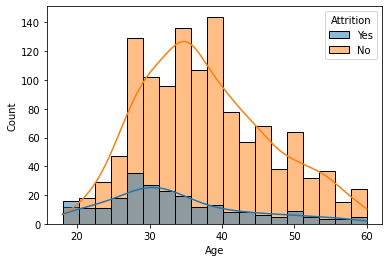

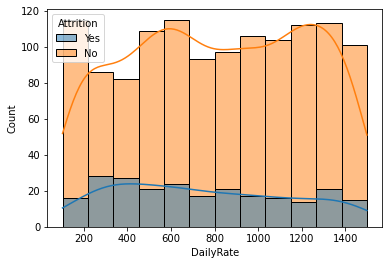

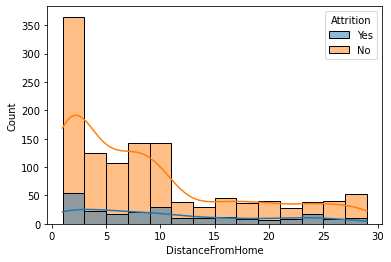

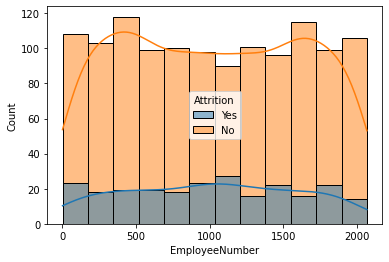

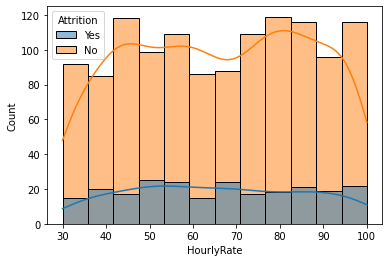

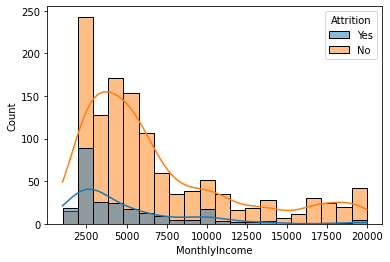

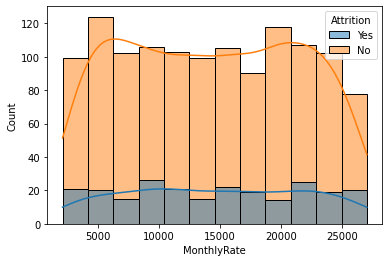

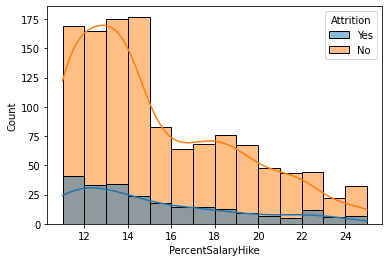

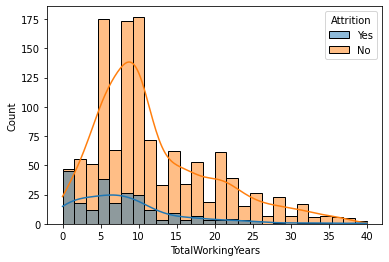

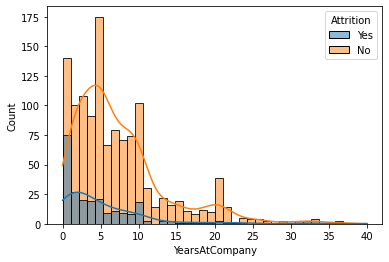

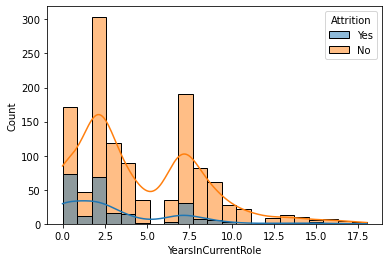

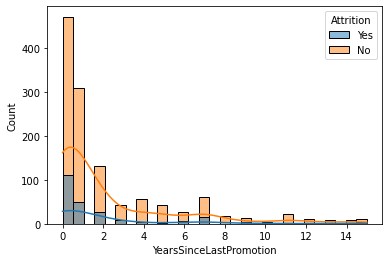

In [15]:
eda.hist_plot()

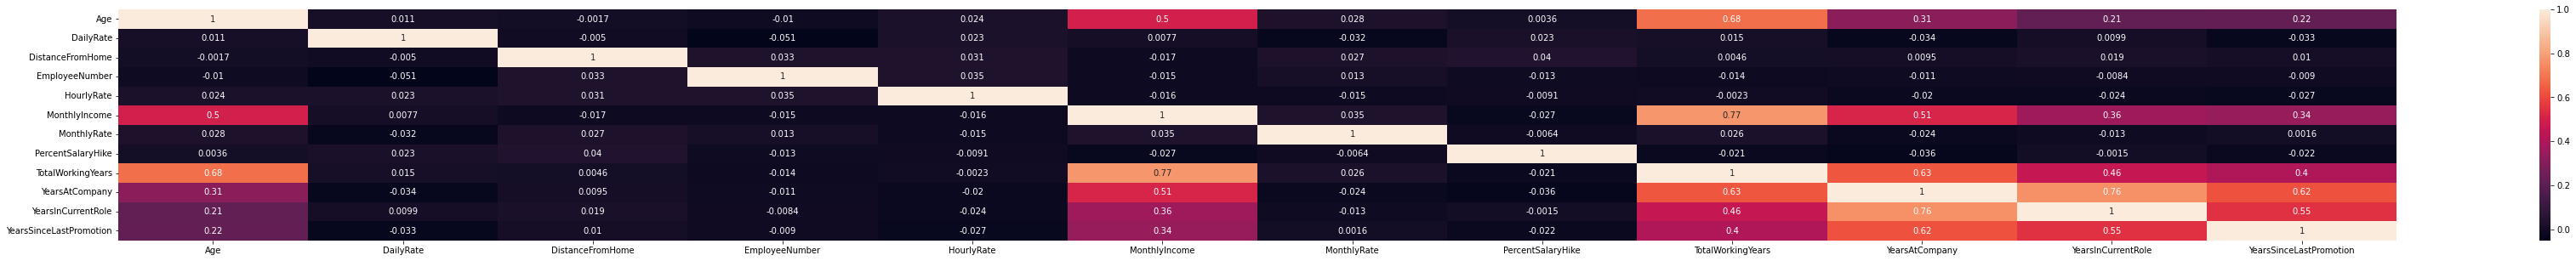

In [16]:
eda.correlation()

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


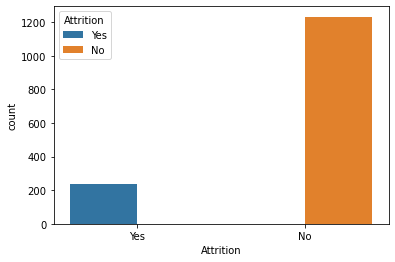

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


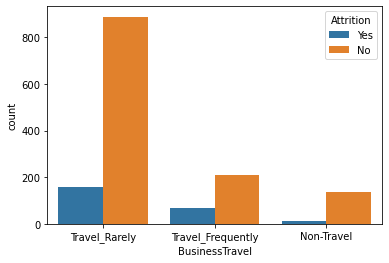

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


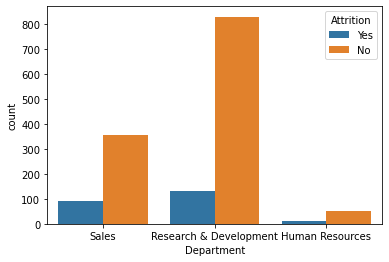

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


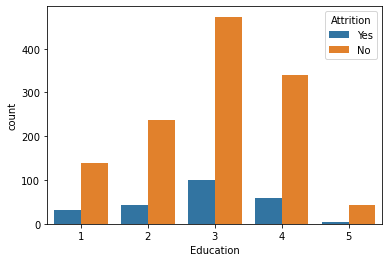

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


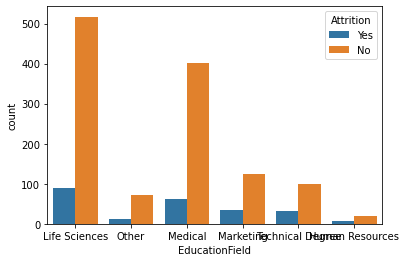

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


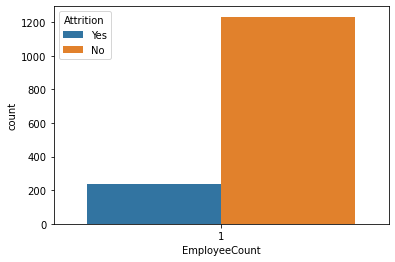

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


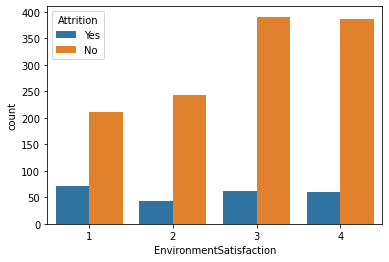

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


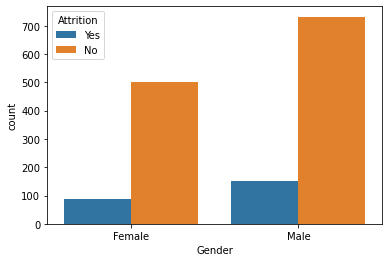

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


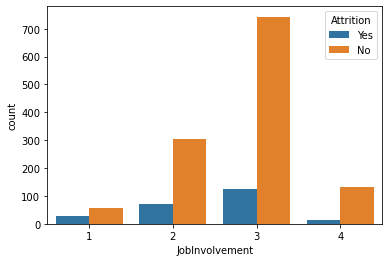

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


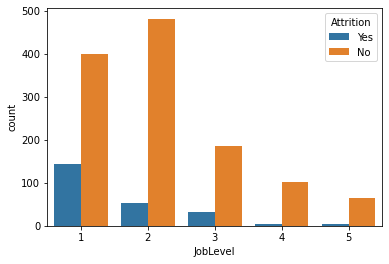

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


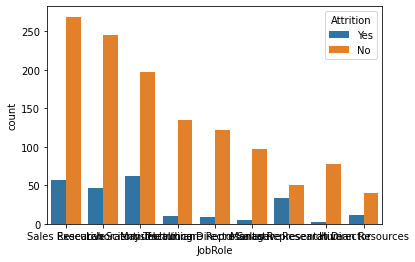

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


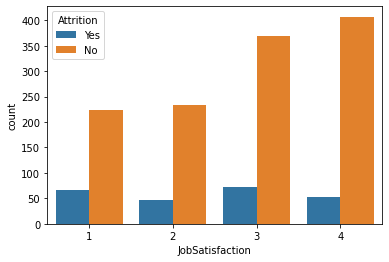

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


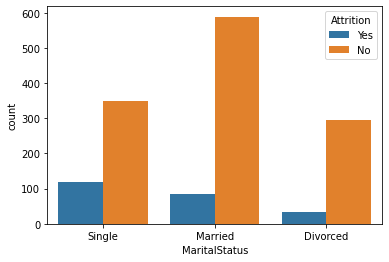

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


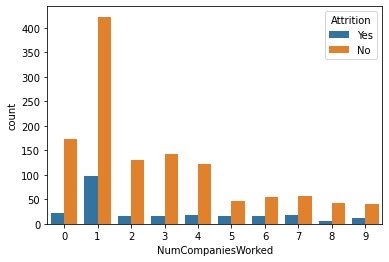

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


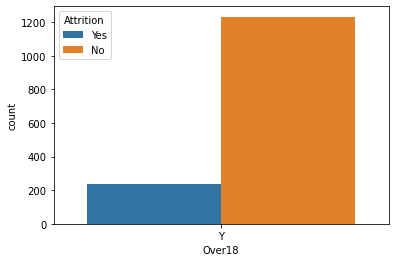

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


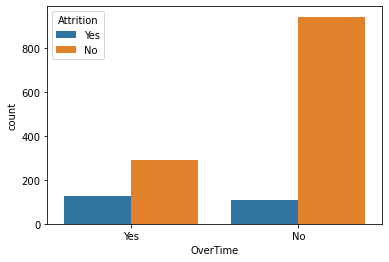

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


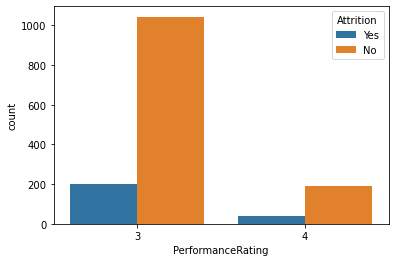

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


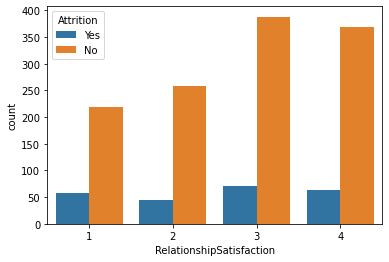

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


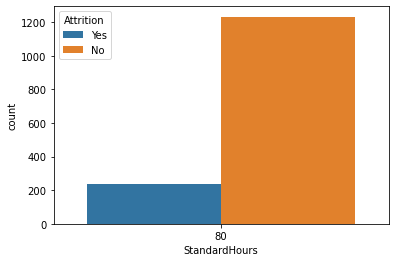

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


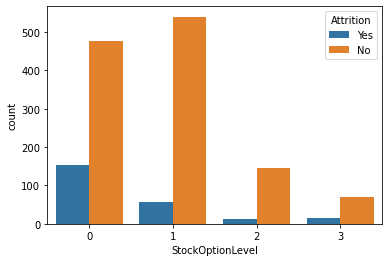

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


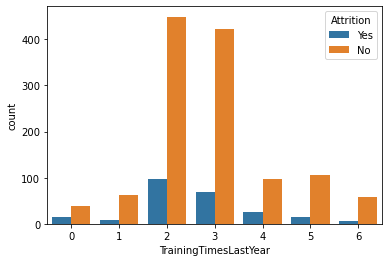

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


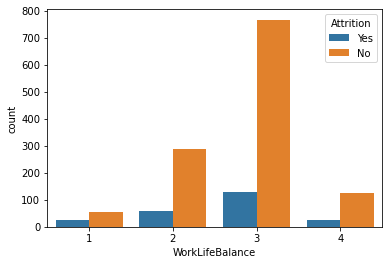

In [17]:
eda.count_plot()

## Drop unusfull features

> ***Over18*** & ***EmployeeCount*** >> because both of them has high-correlations with other features (3 features) **Multicollinearity**
> ***TotalWorkingYears*** & ***YearsAtCompany*** >> all of samples has one-vale **autocorrelation**

In [18]:
dataFrame = dataFrame.drop(['Over18','EmployeeCount', 'TotalWorkingYears','YearsAtCompany'],axis=1)

## Handle non-numerc features

In [19]:
ind = dataFrame.dtypes[dataFrame.dtypes == object].index[1:]
[print(i , dataFrame[i].unique()) for i in ind] 

BusinessTravel ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department ['Sales' 'Research & Development' 'Human Resources']
EducationField ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender ['Female' 'Male']
JobRole ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
MaritalStatus ['Single' 'Married' 'Divorced']
OverTime ['Yes' 'No']


[None, None, None, None, None, None, None]

In [20]:
# for binary features make dummy for them
dataFrame['Gender'] = dataFrame['Gender'].replace(['Female','Male'], [0,1])
dataFrame['OverTime'] = dataFrame['OverTime'].replace(['No','Yes'], [0,1])

ind = ind.drop(['Gender', 'OverTime'])

# for nominal features make dummy for them [assume that all of them nominal]
for i in ind:
    pd.get_dummies(dataFrame[i], dtype=int, 
                                   columns= dataFrame[i].unique())
    dataFrame = dataFrame.drop([i],axis=1)

In [21]:
dataFrame['Attrition'] = dataFrame['Attrition'].replace(['No','Yes'], [0,1])

In [22]:
dataFrame.columns

Index(['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

## split dataFrame

In [23]:
#  into target and features 
x = dataFrame.drop(['Attrition'],axis=1)
y = dataFrame['Attrition']

In [24]:
# into train & test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.3, random_state=5, stratify=y)

# Build - Models

## KNN

In [25]:
knn = KNeighborsClassifier()
params = { 'n_neighbors' : np.arange(1, 12), 'p' :  np.arange(1, 5) }
sCV = StratifiedKFold(10)

In [26]:
model = GridSearchCV(estimator=knn,cv=sCV,n_jobs=10,scoring='roc_auc', param_grid=params)

In [27]:
model.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(), n_jobs=10,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'p': array([1, 2, 3, 4])},
             scoring='roc_auc')

In [28]:
model.best_score_

0.6073271194002862

In [29]:
model.best_params_

{'n_neighbors': 11, 'p': 4}

In [30]:
newKNN = model.estimator

In [31]:
newKNN.p= 4
newKNN.n_neighbors = 11

In [32]:
newKNN.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=11, p=4)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       863
           1       0.82      0.08      0.15       166

    accuracy                           0.85      1029
   macro avg       0.84      0.54      0.54      1029
weighted avg       0.85      0.85      0.79      1029



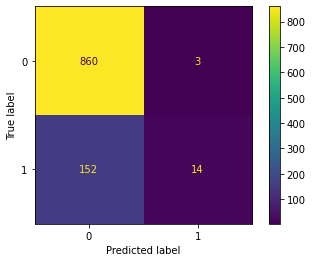

In [33]:
y_pre_tr = newKNN.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       370
           1       0.25      0.01      0.03        71

    accuracy                           0.83       441
   macro avg       0.54      0.50      0.47       441
weighted avg       0.74      0.83      0.77       441



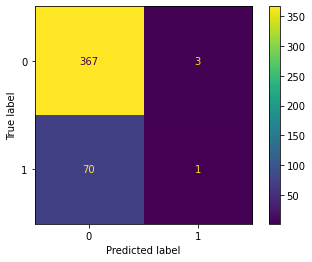

In [34]:
y_pre_te = newKNN.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

## DT

In [120]:
dt = DecisionTreeClassifier()
params = { 'criterion' : ['gini', 'entropy'], 'max_depth' :  np.arange(10, 30), 'min_samples_leaf':np.arange(1, 5)}
sCV = StratifiedKFold(10)

In [121]:
model = GridSearchCV(estimator=dt,cv=sCV,n_jobs=10,scoring='roc_auc', param_grid=params)

In [122]:
model.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29]),
                                        'min_samples_leaf': array([1, 2, 3, 4])},
                   scoring='roc_auc')

In [123]:
model.best_score_

0.6654249856518389

In [124]:
model.best_params_

{'min_samples_leaf': 4, 'max_depth': 13, 'criterion': 'gini'}

In [125]:
newDT = model.best_estimator_

In [126]:
newDT.min_samples_leaf , newDT.max_depth = 4, 13 

In [127]:
newDT.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=13, min_samples_leaf=4)

              precision    recall  f1-score   support

          No       0.94      0.98      0.96       863
         Yes       0.85      0.69      0.76       166

    accuracy                           0.93      1029
   macro avg       0.90      0.83      0.86      1029
weighted avg       0.93      0.93      0.93      1029



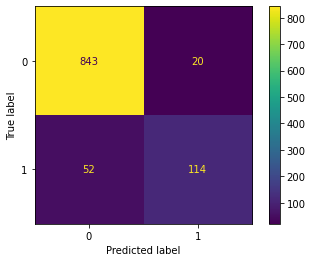

In [128]:
y_pre_tr = newDT.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

              precision    recall  f1-score   support

          No       0.88      0.87      0.88       370
         Yes       0.37      0.39      0.38        71

    accuracy                           0.80       441
   macro avg       0.63      0.63      0.63       441
weighted avg       0.80      0.80      0.80       441



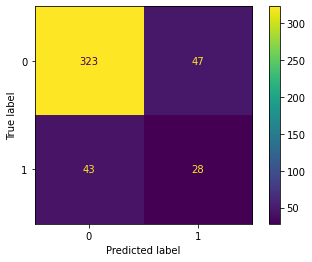

In [129]:
y_pre_te = newDT.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

## Logestic Regression

In [130]:
lg = LogisticRegression()
params = { 'C' : np.arange(1, 10), 'penalty' :  ['l1','l2']}
sCV = StratifiedKFold(10)

In [131]:
model = GridSearchCV(estimator=lg,cv=sCV,n_jobs=10,scoring='roc_auc', param_grid=params)

In [132]:
model.fit(x_train, y_train)

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=LogisticRegression(),
                   param_distributions={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'penalty': ['l1', 'l2']},
                   scoring='roc_auc')

In [133]:
model.best_score_

0.6852761824457129

In [134]:
model.best_params_

{'penalty': 'l2', 'C': 1}

In [135]:
newLR = model.estimator

In [136]:
newLR.C = 1

In [137]:
newLR.fit(x_train,y_train)

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

              precision    recall  f1-score   support

          No       0.84      1.00      0.91       863
         Yes       0.67      0.01      0.02       166

    accuracy                           0.84      1029
   macro avg       0.75      0.51      0.47      1029
weighted avg       0.81      0.84      0.77      1029



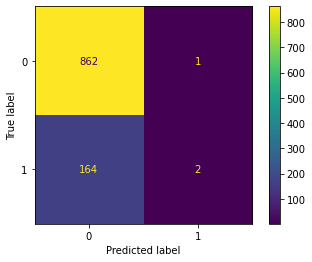

In [138]:
y_pre_tr = newLR.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

              precision    recall  f1-score   support

          No       0.84      1.00      0.91       370
         Yes       1.00      0.01      0.03        71

    accuracy                           0.84       441
   macro avg       0.92      0.51      0.47       441
weighted avg       0.87      0.84      0.77       441



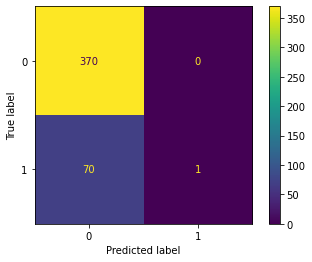

In [139]:
y_pre_te = newLR.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

## BernoulliNB

In [140]:
be = BernoulliNB()
params = { 'alpha' : np.arange(0, 1,0.2), 'binarize' :  np.arange(0, 1,0.2)}
sCV = StratifiedKFold(10)

In [141]:
model = GridSearchCV(estimator=bu,cv=sCV,n_jobs=10,scoring='roc_auc', param_grid=params)

In [142]:
model.fit(x_train, y_train)

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: al

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=BernoulliNB(),
                   param_distributions={'alpha': array([0. , 0.2, 0.4, 0.6, 0.8]),
                                        'binarize': array([0. , 0.2, 0.4, 0.6, 0.8])},
                   scoring='roc_auc')

In [143]:
model.best_score_

0.7552928007610422

In [144]:
model.best_params_

{'binarize': 0.4, 'alpha': 0.0}

In [97]:
newNB = model.estimator

In [145]:
newNB.binarize, newNB.alpha = 0.4,0.0

In [146]:
newNB.fit(x_train,y_train)

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


BernoulliNB(alpha=0.0, binarize=0.4)

              precision    recall  f1-score   support

          No       0.87      0.94      0.90       863
         Yes       0.47      0.28      0.35       166

    accuracy                           0.83      1029
   macro avg       0.67      0.61      0.63      1029
weighted avg       0.81      0.83      0.82      1029



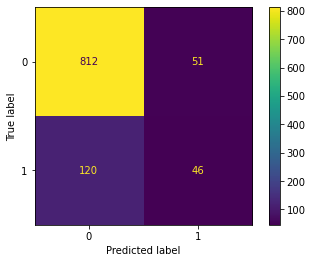

In [147]:
y_pre_tr = newNB.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

              precision    recall  f1-score   support

          No       0.86      0.93      0.90       370
         Yes       0.40      0.24      0.30        71

    accuracy                           0.82       441
   macro avg       0.63      0.59      0.60       441
weighted avg       0.79      0.82      0.80       441



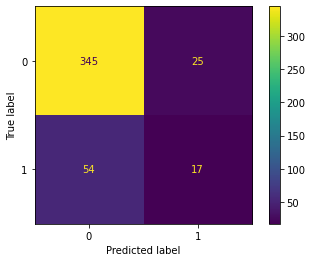

In [148]:
y_pre_te = newNB.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

## AdaBoost

In [149]:
ad = AdaBoostClassifier()
params = { 'n_estimators' : np.arange(50, 200,10), 'learning_rate' :  [0.001, 0.01, 0.1, 1.0]}
sCV = StratifiedKFold(10)

In [150]:
model = RandomizedSearchCV(estimator=ad,cv=sCV,n_iter=10,scoring='roc_auc', param_distributions=params)

In [151]:
model.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=AdaBoostClassifier(),
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1,
                                                          1.0],
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190])},
                   scoring='roc_auc')

In [152]:
model.best_score_

0.7960353868893186

In [153]:
model.best_params_

{'n_estimators': 60, 'learning_rate': 0.1}

In [154]:
newAD = model.estimator

In [155]:
newAD.n_estimators, newAD.learning_rate = 60, 0.1

In [157]:
newAD.fit(x_train,y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=60)

              precision    recall  f1-score   support

          No       0.86      1.00      0.92       863
         Yes       0.95      0.12      0.21       166

    accuracy                           0.86      1029
   macro avg       0.90      0.56      0.57      1029
weighted avg       0.87      0.86      0.81      1029



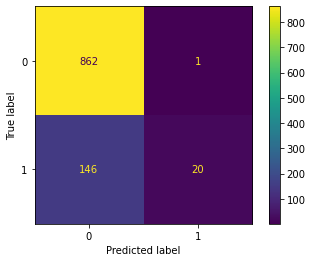

In [158]:
y_pre_tr = newAD.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

              precision    recall  f1-score   support

          No       0.88      0.87      0.88       370
         Yes       0.37      0.39      0.38        71

    accuracy                           0.80       441
   macro avg       0.63      0.63      0.63       441
weighted avg       0.80      0.80      0.80       441



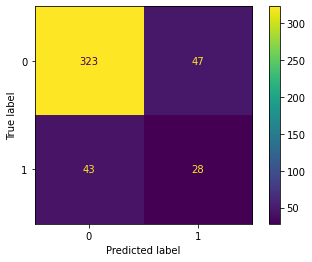

In [159]:
y_pre_te = newDT.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

In [42]:
lg = LogisticRegression()
params = { 'C' : np.arange(1, 10), 'penalty' :  ['l1','l2']}
sCV = StratifiedKFold(10)

In [43]:
model = RandomizedSearchCV(estimator=lg,cv=sCV,n_iter=10,scoring='accuracy', param_distributions=params)

In [78]:
model.fit(x_train, y_train)

In [52]:
model.best_score_

0.8454787740338853

In [53]:
model.best_params_

{'penalty': 'l2', 'C': 6}

In [54]:
newLR = model.estimator

In [57]:
newLR.C = 6

In [58]:
newLR.fit(x_train,y_train)

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=6)

              precision    recall  f1-score   support

          No       0.94      0.98      0.96       868
         Yes       0.84      0.67      0.74       161

    accuracy                           0.93      1029
   macro avg       0.89      0.82      0.85      1029
weighted avg       0.92      0.93      0.92      1029



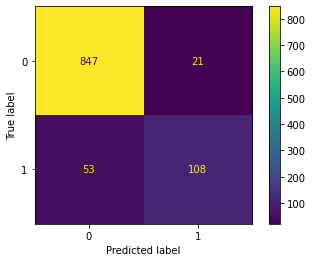

In [59]:
y_pre_tr = newDT.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

              precision    recall  f1-score   support

          No       0.87      0.91      0.89       365
         Yes       0.44      0.36      0.39        76

    accuracy                           0.81       441
   macro avg       0.66      0.63      0.64       441
weighted avg       0.80      0.81      0.80       441



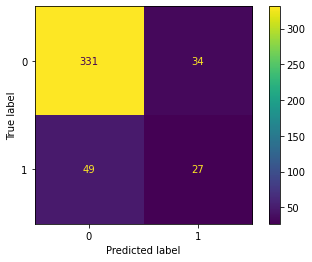

In [60]:
y_pre_te = newDT.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

## GradientBoost

In [ ]:
gb = GradientBoostingClassifier()

params = { 'learning_rate' : [0.001,0.01,0.1,1.0], 'n_estimators' :  [100,200,300],
           'min_samples_split' : np.arange(2,7), 'min_samples_leaf' : np.arange(1,32),
           'max_depth' : np.arange(3,12)}

sCV = StratifiedKFold(10)

In [ ]:
model = RandomizedSearchCV(estimator=gb,cv=sCV,n_iter=10,scoring='roc_auc', param_distributions=params)

In [ ]:
model.fit(x_train, y_train)

In [163]:
model.best_score_

0.7925307994087772

In [164]:
model.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 15,
 'max_depth': 5,
 'learning_rate': 0.01}

In [165]:
newGB = model.estimator

In [166]:
newGB.n_estimators ,newGB.min_samples_split ,newGB.min_samples_leaf ,newGB.max_depth ,newGB.learning_rate = 300,2,15,5,0.01

In [167]:
newGB.fit(x_train,y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=15,
                           n_estimators=300)

              precision    recall  f1-score   support

          No       0.93      1.00      0.97       863
         Yes       0.99      0.64      0.78       166

    accuracy                           0.94      1029
   macro avg       0.96      0.82      0.87      1029
weighted avg       0.94      0.94      0.94      1029



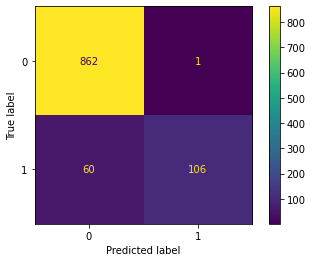

In [168]:
y_pre_tr = newGB.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

              precision    recall  f1-score   support

          No       0.88      0.87      0.88       370
         Yes       0.37      0.39      0.38        71

    accuracy                           0.80       441
   macro avg       0.63      0.63      0.63       441
weighted avg       0.80      0.80      0.80       441



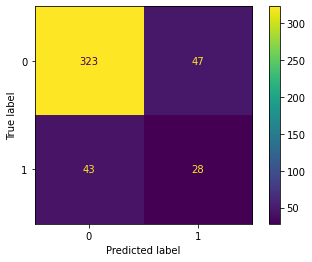

In [169]:
y_pre_te = newDT.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

## XGradientBoost 

In [36]:
xg = xgb.XGBClassifier(objective='binary:logistic', subsample=0.9, colsample_bytree=0.5)

lis = np.arange(0.1,1, 0.1).tolist()
lis.extend(np.arange(1,11).tolist())
lis.extend(np.arange(80,1001).tolist())

params = { 'learning_rate' : [0.001,0.01,0.,1.0], 'n_estimators' :  [100,200,300],
           'scale_pos_weight' : np.arange(2,7),
           'max_depth' : np.arange(3,12), 'gamma' : lis,
           'reg_lambda' : lis}
sCV = StratifiedKFold(10)

In [37]:
model = RandomizedSearchCV(estimator=xg, cv=sCV,scoring='roc_auc', param_distributions=params)

In [38]:
model.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.5,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           int...
                                                  1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  80, 81, 82, 83, 84, 85, 86,
                      

In [40]:
model.best_score_

0.5

In [41]:
model.best_params_

{'scale_pos_weight': 5,
 'reg_lambda': 854,
 'n_estimators': 200,
 'max_depth': 3,
 'learning_rate': 0.01,
 'gamma': 865}

In [42]:
newXG = model.estimator

In [43]:
newXG.scale_pos_weight ,newXG.reg_lambda ,newXG.n_estimators ,newXG.max_depth ,newXG.learning_rate ,newXG.gamma = \
5,854,200,3,0.01,865

In [44]:
newXG.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=865, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=854, ...)

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       863
           1       0.00      0.00      0.00       166

    accuracy                           0.84      1029
   macro avg       0.42      0.50      0.46      1029
weighted avg       0.70      0.84      0.77      1029



C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


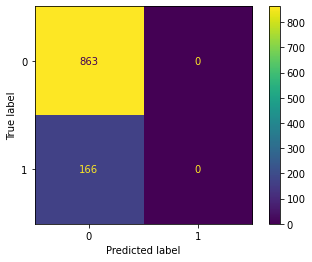

In [45]:
y_pre_tr = newXG.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       370
           1       0.00      0.00      0.00        71

    accuracy                           0.84       441
   macro avg       0.42      0.50      0.46       441
weighted avg       0.70      0.84      0.77       441



C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


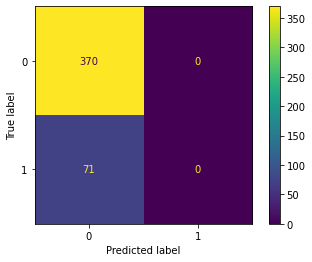

In [46]:
y_pre_te = newXG.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

## SVC

In [47]:
svc = SVC()
params = { 'C' : np.arange(1, 12), 'degree' :  np.arange(1, 5), 'kernel': ['linear', 'rbf', 'sigmoid']}
sCV = StratifiedKFold(10)

In [48]:
model = RandomizedSearchCV(estimator=svc,cv=sCV,n_iter=10,scoring='accuracy', param_distributions=params)

In [ ]:
model.fit(x_train, y_train)

In [ ]:
model.best_score_

In [ ]:
model.best_params_

In [ ]:
newSVC = model.estimator

In [ ]:
newSVC.C=
newSVC.degree=
newSVC.kernal=

In [ ]:
newSVC.fit(x_train,y_train)

In [ ]:
y_pre_tr = newSVC.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

In [ ]:
y_pre_te = newSVC.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

> SVC take much time  